## Assignemnt 3: GeoPython 

### Exploring sentinel1-GRD products using pystac_client package

In this exercise, I tried to use pystac_client package primarily along with other packages (odc-stac, geopandas, rasterio, numpy) to build the python class "Sentinel1GRDProcessor" for the "pysarflow" package development and add search_data functionality to support folllowing activities:
- To search the sentinel-1 GRD products for the area-of-interest (AOI) using the STAC api
- visualize the thumbnail (new)
- Explore the properties and assets of data
- Read the vv and vh band and visualize
- Crop data with AOI

To setup the project environment run: 

``` conda env create -f env.yml ```

To activate the environment:

``` conda activate python_a3_temp_env ```

Sources:

Pystac-client:
- To search data: [https://pystac-client.readthedocs.io/en/latest/usage.html](https://pystac-client.readthedocs.io/en/latest/usage.html) library.

- To visualize metadata: [https://pystac-client.readthedocs.io/en/stable/tutorials/stac-metadata-viz.html](https://pystac-client.readthedocs.io/en/stable/tutorials/stac-metadata-viz.html) were used.

odc-stac
- To load the data:[https://pystac-client.readthedocs.io/en/latest/usage.html#loading-data](https://pystac-client.readthedocs.io/en/latest/usage.html#loading-data)


### Importing packages

In [1]:
from pystac_client import Client
from pystac import ItemCollection

import requests
from PIL import Image
from io import BytesIO
import numpy as np
import math

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import shape

import rioxarray 
import odc.stac
import hvplot.pandas

pd.set_option('display.max_columns', None) # setting to display all columns
pd.set_option('display.max_colwidth', None) # settings to display full content of each cell

import logging
logging.getLogger("pystac_client").setLevel(logging.WARNING)

### Connecting to Earth Search API to list and print all available data collection IDs

It contains total 9 collection and one of them is **sentinel-1-grd**, in which we are working on

In [2]:
client = Client.open("https://earth-search.aws.element84.com/v1")

collection_search = client.collection_search()
    
print(f"** {collection_search.matched()} collections found **")

for collection in collection_search.collections():
    print(collection.id)

** 9 collections found **
sentinel-2-pre-c1-l2a
cop-dem-glo-30
naip
cop-dem-glo-90
landsat-c2-l2
sentinel-2-l2a
sentinel-2-l1c
sentinel-2-c1-l2a
sentinel-1-grd


### Helper functions

In [3]:
def s3_to_https(s3_url):
    '''
    Convert an S3 URL (s3://bucket/key) to its equivalent HTTPS URL for web access
    '''
    if not s3_url.startswith("s3://"):
        raise ValueError("Not a valid S3 path.")
    s3_path = s3_url.replace("s3://", "")
    bucket, *key_parts = s3_path.split("/")
    key = "/".join(key_parts)
    return f"https://{bucket}.s3.amazonaws.com/{key}"


def items_to_geodataframe(items):
    ''' 
        Convert a list of STAC Items into a GeoDataFrame
    '''
    _items = []
    for i in items:
        _i = {
            "id": i["id"],
            "type": i["type"],
            "stac_version": i["stac_version"],
            "links": i["links"],
            "stac_extensions": i["stac_extensions"],
            "bbox": i["bbox"],
            "geometry": shape(i["geometry"]),
        }
        _items.append(_i)
    return gpd.GeoDataFrame(_items, geometry="geometry")

def plot_bbox(data, *args, **kwargs):
    '''
    plot aoi on a map with background tiles
    source: https://pystac-client.readthedocs.io/en/stable/tutorials/stac-metadata-viz.html
    '''
    return data.hvplot.polygons(
        *args,
        geo=True,
        projection="GOOGLE_MERCATOR",
        xaxis=None,
        yaxis=None,
        frame_width=600,
        frame_height=600,
        fill_alpha=0,
        line_width=4,
        **kwargs,
    )
        
def plot_thumbnails(df_assets, df_properties, n_cols=4):
    '''
        Plot image thumbnails from assets DataFrame in a grid layout with titles.

        Parameters:
        - df_assets (pd.DataFrame): DataFrame containing asset information including S3 thumbnail URLs and IDs.
        - df_properties (pd.DataFrame): DataFrame containing additional properties for assets
        - n_cols (Integer): number of columns in a row to plot image
        The function:
        - Converts S3 URLs to HTTPS URLs to fetch thumbnail images.
        - Retrieves and displays thumbnails in a grid (default 4 columns).
        - Sets titles using asset IDs and orbit pass information.
    '''
    try:
        if df_assets is None:
            raise ValueError("Asset DataFrame is not initialized. Ensure data is loaded before proceeding.")
        thumbnails = []
        titles = []

        # Collect thumbnails and titles
        for _, item in df_assets.iterrows():
            s3_url = item["thumbnail"]
            https_url = s3_to_https(s3_url)
            try:
                response = requests.get(https_url)
                response.raise_for_status()
                img = Image.open(BytesIO(response.content)).convert("RGB")
                thumbnails.append(img)
                
                properties = df_properties[df_properties["id"] == item["id"]]
                orbit_state = properties.iloc[0]["sat:orbit_state"]

                titles.append(f'{item["id"].split("_")[-3]}, Pass: {orbit_state}')

            except Exception as e:
                print(f"Failed to load thumbnail for {item.id}: {e}")

        # Determine grid layout
        n_images = len(thumbnails)
        n_cols = n_cols
        n_rows = math.ceil(n_images / n_cols)

        # Plot thumbnails in grid
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
        axes = axes.flatten()

        for idx, ax in enumerate(axes):
            if idx < n_images:
                ax.imshow(thumbnails[idx])
                ax.set_title(titles[idx], fontsize=9)
                ax.axis('off')
            else:
                ax.axis('off')  # Hide unused subplots

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Unexpected error occurred in plot_thumbnails:", str(e))

### Creating python class that handle searching sentinel-1 GRD products

In [4]:
class Sentinel1GRDProcessor:
    """
    A processor class to search and explore Sentinel-1 GRD data from the Earth Search STAC API.

    Attributes
    ----------
    api_url : str
        The URL of the STAC API endpoint. Defaults to the Earth Search AWS endpoint.
    client : Client
        An instance of the STAC API client connected to the specified api_url.
    search : Search
        The STAC API search object resulting from a data query.
    items : list
        A list of search results as dictionaries (STAC items).
    item_collection : ItemCollection
        A collection of STAC items from the search results.
    gdf_aoi : GeoDataFrame
        GeoDataFrame representing the Area of Interest (AOI) geometry.
    gdf_metadata : GeoDataFrame
        GeoDataFrame containing spatial metadata.
    df_properties : pandas.DataFrame
        DataFrame holding properties of each STAC item.
    df_assets : pandas.DataFrame
        DataFrame holding asset URLs for each STAC item.

    Methods
    -------
    search_data(aoi: dict, datetime: str):
        Searches Sentinel-1 GRD data within a given Area of Interest (AOI) and datetime range
    """

    def __init__(self, api_url="https://earth-search.aws.element84.com/v1"):
        """
        Initializes the Sentinel1GRDProcessor with a connection to the specified STAC API.

        Parameters
        ----------
        api_url : str, optional
            The URL of the STAC API endpoint to connect to Earth Search AWS.
        """
         
        self.api_url = api_url
        self.client = Client.open(api_url)

        self.search = None
        self.items = None
        self.item_collection = None
        self.gdf_aoi = None
        self.gdf_metadata = None
        self.df_properties = None
        self.df_assets = None

    def search_data(self, aoi: dict, datetime: str,):

        """
        Search Sentinel-1 GRD data using STAC API for a specified area and time range.
        
        Parameters
        ----------
        aoi : dict
            GeoJSON defining the Area of Interest for the search.
        datetime : str
            datetime range string for filtering the data, e.g., "2023-01-01/2023-01-31".
        """
        self.aoi=aoi
        self.datetime=datetime

        self.search = self.client.search(
            collections=["sentinel-1-grd"],
            intersects=self.aoi,
            datetime=self.datetime
        )
        
        self.items = list(self.search.items_as_dicts())
        self.item_collection = ItemCollection(self.search.get_items())

        # Convert AOI to GeoDataFrame
        self.gdf_aoi = gpd.GeoDataFrame([{"geometry": shape(self.aoi)}])

        # Convert items to GeoDataFrame and property/asset DataFrames
        self.gdf_metadata = items_to_geodataframe(self.items)

        item_properties = []
        item_assets = []

        for item in self.item_collection:
            item_properties.append({"id": item.id, **item.properties})
            item_assets.append({"id": item.id, **{k: v.href for k, v in item.assets.items()}})

        self.df_properties = pd.DataFrame(item_properties)
        self.df_assets = pd.DataFrame(item_assets)

In [5]:
# Defining area of interest in geojson format
aoi_polygon = {"type":"Polygon",
               "coordinates":[[
                   [-118.185081,34.137719],
                   [-118.185081,34.266631],
                   [-117.983208,34.266631],
                   [-117.983208,34.137719],
                   [-118.185081,34.137719]]]}

# Creating processor instance from Sentinel1GRDProcessor class
processor = Sentinel1GRDProcessor()

# Running search data function using processor instance
processor.search_data(aoi=aoi_polygon, datetime = "2025-01-05/2025-01-10")

/Users/rabinatwayana/Rabina/anaconda3/envs/python_a3_temp_env/lib/python3.10/site-packages/pystac_client/item_search.py:881: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


In [6]:
# Visualizing bbox and aoi using hvplot
# The * Holoviews operator to overlay two plots
plot_bbox(processor.gdf_metadata, tiles="OSM") * plot_bbox(processor.gdf_aoi, line_color="red")

:Overlay
   .WMTS.I      :WMTS   [Longitude,Latitude]
   .Polygons.I  :Polygons   [Longitude,Latitude]
   .Polygons.II :Polygons   [Longitude,Latitude]

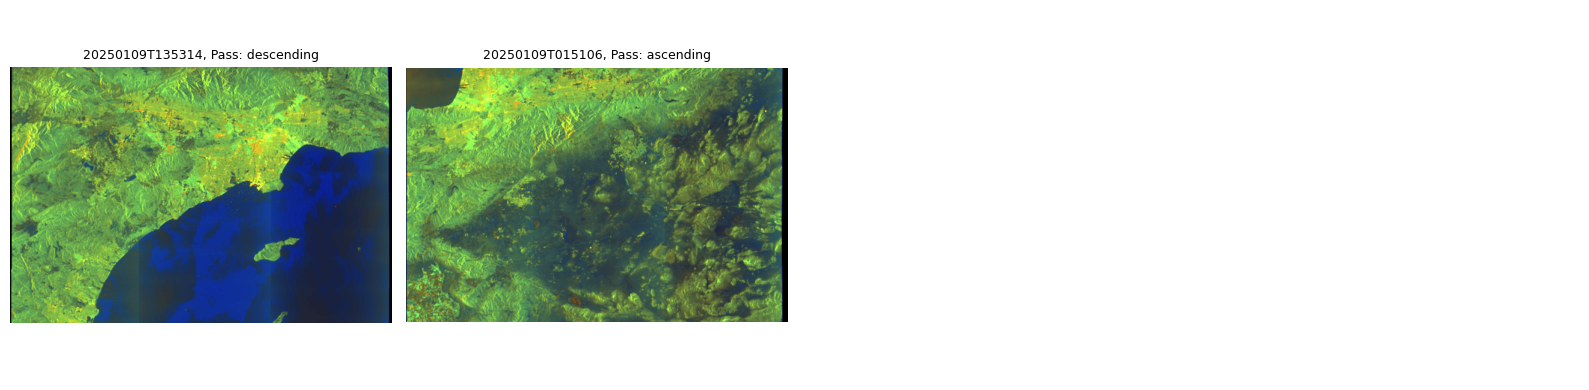

In [7]:
# Function call to plot the thumbnail
plot_thumbnails(processor.df_assets, processor.df_properties)

In [8]:
# Accessing the GeoDataFrame 'gdf_metadata' from the 'processor' object
processor.gdf_metadata

,id,type,stac_version,links,stac_extensions,bbox,geometry
0,S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87,Feature,1.0.0,"[{'rel': 'self', 'type': 'application/geo+json', 'href': 'https://earth-search.aws.element84.com/v1/collections/sentinel-1-grd/items/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87'}, {'rel': 'canonical', 'href': 's3://earthsearch-data/sentinel-1-grd/2025/1/9/IW/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87.json', 'type': 'application/json'}, {'rel': 'parent', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1/collections/sentinel-1-grd'}, {'rel': 'collection', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1/collections/sentinel-1-grd'}, {'rel': 'root', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1'}, {'rel': 'thumbnail', 'href': 'https://earth-search.aws.element84.com/v1/collections/sentinel-1-grd/items/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87/thumbnail'}]","[https://stac-extensions.github.io/projection/v1.1.0/schema.json, https://stac-extensions.github.io/raster/v1.1.0/schema.json, https://stac-extensions.github.io/sar/v1.0.0/schema.json, https://stac-extensions.github.io/storage/v1.0.0/schema.json, https://stac-extensions.github.io/sat/v1.0.0/schema.json, https://stac-extensions.github.io/processing/v1.1.0/schema.json]","[-119.3335521, 32.6737633, -116.3709724, 34.5764799]","POLYGON ((-119.04225 34.57648, -119.33355 33.07168, -118.02058 32.88154, -116.69502 32.67376, -116.37097 34.18318, -117.72928 34.39095, -119.04225 34.57648))"
1,S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36,Feature,1.0.0,"[{'rel': 'self', 'type': 'application/geo+json', 'href': 'https://earth-search.aws.element84.com/v1/collections/sentinel-1-grd/items/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36'}, {'rel': 'canonical', 'href': 's3://earthsearch-data/sentinel-1-grd/2025/1/9/IW/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36.json', 'type': 'application/json'}, {'rel': 'parent', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1/collections/sentinel-1-grd'}, {'rel': 'collection', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1/collections/sentinel-1-grd'}, {'rel': 'root', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1'}, {'rel': 'thumbnail', 'href': 'https://earth-search.aws.element84.com/v1/collections/sentinel-1-grd/items/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36/thumbnail'}]","[https://stac-extensions.github.io/storage/v1.0.0/schema.json, https://stac-extensions.github.io/raster/v1.1.0/schema.json, https://stac-extensions.github.io/processing/v1.1.0/schema.json, https://stac-extensions.github.io/sar/v1.0.0/schema.json, https://stac-extensions.github.io/projection/v1.1.0/schema.json, https://stac-extensions.github.io/sat/v1.0.0/schema.json]","[-119.1324767, 33.76746, -116.1038947, 35.6694387]","POLYGON ((-116.41259 35.66944, -117.75673 35.48268, -119.13248 35.27527, -118.92101 34.36297, -118.79786 33.76746, -117.47883 33.97123, -116.10389 34.1669, -116.41259 35.66944))"


In [9]:
# To get the column names in properties dataframe
processor.df_properties.columns

Index(['id', 'sar:frequency_band', 'sar:center_frequency',
       'sar:observation_direction', 'sar:instrument_mode', 'sar:polarizations',
       'sar:product_type', 'sar:resolution_range', 'sar:resolution_azimuth',
       'sar:pixel_spacing_range', 'sar:pixel_spacing_azimuth',
       'sar:looks_range', 'sar:looks_azimuth', 'sar:looks_equivalent_number',
       'sat:platform_international_designator', 'sat:orbit_state',
       'sat:absolute_orbit', 'sat:relative_orbit', 'proj:bbox', 'proj:shape',
       'proj:transform', 'proj:centroid', 'platform', 'constellation',
       'start_datetime', 'end_datetime', 's1:instrument_configuration_ID',
       's1:datatake_id', 's1:product_timeliness', 's1:processing_level',
       's1:resolution', 's1:orbit_source', 's1:slice_number',
       's1:total_slices', 's1:shape', 's1:product_identifier',
       's1:processing_datetime', 'storage:platform', 'storage:region',
       'storage:requester_pays', 'datetime', 'processing:software', 'created',
    

In [10]:
# Accessing the DataFrame 'df_properties' from the 'processor' object
processor.df_properties

,id,sar:frequency_band,sar:center_frequency,sar:observation_direction,sar:instrument_mode,sar:polarizations,sar:product_type,sar:resolution_range,sar:resolution_azimuth,sar:pixel_spacing_range,sar:pixel_spacing_azimuth,sar:looks_range,sar:looks_azimuth,sar:looks_equivalent_number,sat:platform_international_designator,sat:orbit_state,sat:absolute_orbit,sat:relative_orbit,proj:bbox,proj:shape,proj:transform,proj:centroid,platform,constellation,start_datetime,end_datetime,s1:instrument_configuration_ID,s1:datatake_id,s1:product_timeliness,s1:processing_level,s1:resolution,s1:orbit_source,s1:slice_number,s1:total_slices,s1:shape,s1:product_identifier,s1:processing_datetime,storage:platform,storage:region,storage:requester_pays,datetime,processing:software,created,updated,proj:code
0,S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87,C,5.405,right,IW,"[VV, VH]",GRD,20,22,10,10,5,1,4.4,2014-016A,descending,57368,71,"[-119.366325, 32.671017, -116.354919, 34.583099]","[25566, 16716]","[0.00018015111270638958, 0, -119.366325, 0, -7.479003363842596e-05, 34.583099]","{'lat': 33.62965, 'lon': -117.87058}",sentinel-1a,sentinel-1,2025-01-09T13:52:49.295428Z,2025-01-09T13:53:14.293838Z,7,462727,Fast-24h,1,high,RESORB,8,13,"[25566, 16716]",S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3,2025-01-09T15:47:44.000000Z,AWS,eu-central-1,True,2025-01-09T13:53:01.794633Z,{'sentinel1-to-stac': '2023.05.17'},2025-01-09T16:32:28.056Z,2025-01-09T16:32:28.056Z,EPSG:4326
1,S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36,C,5.405,right,IW,"[VV, VH]",GRD,20,22,10,10,5,1,4.4,2014-016A,ascending,57361,64,"[-119.133232, 33.767582, -116.060799, 35.677593]","[25670, 16703]","[0.00018394497994372291, 0, -119.133232, 0, -7.440634982469825e-05, 35.677593]","{'lat': 34.72518, 'lon': -117.58633}",sentinel-1a,sentinel-1,2025-01-09T01:50:41.193183Z,2025-01-09T01:51:06.192259Z,7,462646,Fast-24h,1,high,RESORB,2,12,"[25670, 16703]",S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1,2025-01-09T06:30:23.000000Z,AWS,eu-central-1,True,2025-01-09T01:50:53.692721Z,{'sentinel1-to-stac': '2023.05.17'},2025-01-09T06:46:57.984Z,2025-01-09T06:46:57.984Z,EPSG:4326


In [11]:
# To only access the interested properties
processor.df_properties[['id',"sar:polarizations", "sar:resolution_range","sat:orbit_state","proj:code"]]

,id,sar:polarizations,sar:resolution_range,sat:orbit_state,proj:code
0,S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87,"[VV, VH]",20,descending,EPSG:4326
1,S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36,"[VV, VH]",20,ascending,EPSG:4326


In [12]:
# To get the column names in assets dataframe
processor.df_assets.columns


Index(['id', 'safe-manifest', 'schema-product-vh', 'schema-product-vv',
       'schema-calibration-vh', 'schema-calibration-vv', 'schema-noise-vh',
       'schema-noise-vv', 'thumbnail', 'vh', 'vv'],
      dtype='object')

In [13]:
# Accessing the DataFrame 'df_properties' from the 'processor' object
processor.df_assets

,id,safe-manifest,schema-product-vh,schema-product-vv,schema-calibration-vh,schema-calibration-vv,schema-noise-vh,schema-noise-vv,thumbnail,vh,vv
0,S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3/manifest.safe,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3/annotation/rfi/rfi-iw-vh.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3/annotation/rfi/rfi-iw-vv.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3/annotation/calibration/calibration-iw-vh.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3/annotation/calibration/calibration-iw-vv.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3/annotation/calibration/noise-iw-vh.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3/annotation/calibration/noise-iw-vv.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3/preview/quick-look.png,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3/measurement/iw-vh.tiff,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T135249_20250109T135314_057368_070F87_CBE3/measurement/iw-vv.tiff
1,S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1/manifest.safe,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1/annotation/rfi/rfi-iw-vh.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1/annotation/rfi/rfi-iw-vv.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1/annotation/calibration/calibration-iw-vh.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1/annotation/calibration/calibration-iw-vv.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1/annotation/calibration/noise-iw-vh.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1/annotation/calibration/noise-iw-vv.xml,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1/preview/quick-look.png,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1/measurement/iw-vh.tiff,s3://sentinel-s1-l1c/GRD/2025/1/9/IW/DV/S1A_IW_GRDH_1SDV_20250109T015041_20250109T015106_057361_070F36_B4F1/measurement/iw-vv.tiff


### Load the data using odc-stac
source: https://pystac-client.readthedocs.io/en/latest/usage.html#loading-data

It loads load asset data from Items or an ItemCollection into an xarray.

/Users/rabinatwayana/Rabina/anaconda3/envs/python_a3_temp_env/lib/python3.10/site-packages/pystac_client/item_search.py:881: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


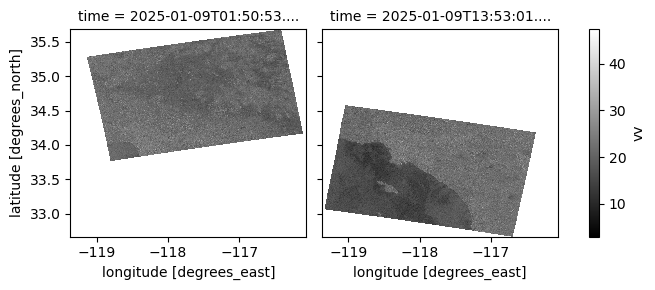

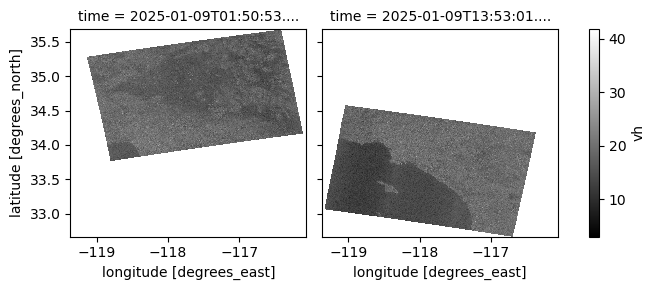

In [14]:
sar_data = odc.stac.load(
    processor.search.get_items(),
    bands=["vv", "vh"],
)

sar_data_dB = sar_data.copy()
sar_data_dB['vv'] = 10 * np.log10(sar_data.vv.where(sar_data.vv > 0)) 
sar_data_dB['vh'] = 10 * np.log10(sar_data.vh.where(sar_data.vh > 0))

# Visualize VV band
sar_data_dB.vv.plot.imshow(col="time", cmap="gray")

#Visualize VH band
sar_data_dB.vh.plot.imshow(col="time", cmap="gray")


### Clip data by AOI

**vv band**


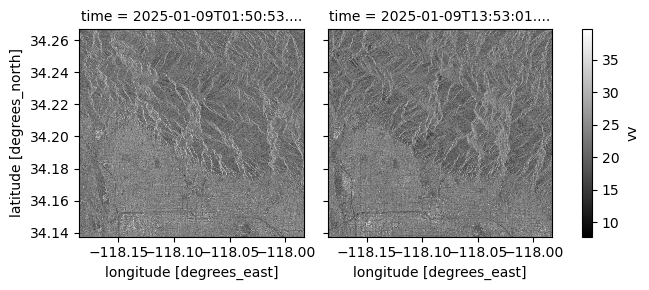

In [16]:
vv = sar_data_dB['vv']
vh = sar_data_dB['vh']

vv_clipped = vv.rio.clip(processor.gdf_aoi.geometry)
vh_clipped = vh.rio.clip(processor.gdf_aoi.geometry)

# Visualize vv band after clipping
print("**vv band**")
vv_clipped.plot.imshow(col="time", cmap="gray")


**vh band**


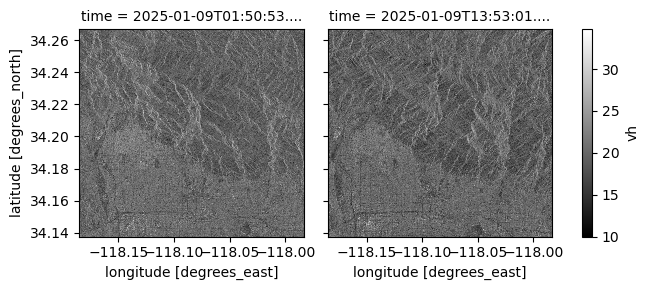

In [17]:
# Visualize vh band after clipping
print("**vh band**")
vh_clipped.plot.imshow(col="time", cmap="gray")